In [1]:
import pandas as pd
import numpy as np
import os
import PIL
from PIL import Image

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [3]:
# Load the VGG weigths
path_weights_tf = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG_16(path_weights_tf)

In [4]:
def crop(img, m):
    half_the_width = img.size[0] / 2.
    half_the_height = img.size[1] / 2.
    img4 = img.crop((
    half_the_width - m,
    half_the_height - m,
    half_the_width + m,
    half_the_height + m))
    return(img4)

In [5]:
size = 224
def read_image(f,m):
    try:
        im = Image.open(f)
        im = crop(im,m)
        im = im.resize((size, size), PIL.Image.BILINEAR)
        im = np.array(im, dtype='float64')
        if len(im.shape)==2:
            im = im.reshape(im.shape[0],im.shape[1],1)
            im = im.repeat(3,axis=2)
        if im.shape[2]!=3:
            im = im[:,:,:3]
        im[:,:,0] -= 103.939
        im[:,:,1] -= 116.779
        im[:,:,2] -= 123.68
        im = im.reshape(1,224,224,3)
        return(im)
    except ValueError:
        print(f) #print the shape of im if it doesn't work correctly, don't reference this apriori

In [6]:
# with a Sequential model, get output of only 33rd layer
get_33rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[32].output])

In [7]:
def mlp_network():
    mlp = Sequential()
    mlp.add(Dense(128, input_dim=4096, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(6, activation='softmax'))
    # mlp.summary()

    mlp.compile(optimizer='Adam', 
                loss='categorical_crossentropy', 
                metrics=['acc'])
    return(mlp)

In [8]:
mlp = mlp_network()
mlp.load_weights('mlp_model_6_73.h5')

In [9]:
def get_labels(l):
    labels = ['A' if i==0 else 'B' if i==1 else 'C' if i==2 else 'Five' if i==3 else 'Point' if i==4 else 'V' for i in l]
    return(labels)

full_val_path = []
def predictions_df(path):
    x_val = []
    for root, dirs, files in os.walk(path):
        files.sort(key=lambda f: int(filter(str.isdigit, f)))
        i=0
        for f in files:
            full_val_path.append(os.path.join(root,f))
            im1 = read_image(os.path.join(root,f), m=28)
            temp = get_33rd_layer_output([im1])[0]
            x_val.append(temp[0])
            i+=1
    x_val = np.array(x_val)
    y_val = mlp.predict_classes(x_val)
    y_val_labels = get_labels(y_val)
    val_upload = pd.DataFrame({'FileName':files, 'Label':y_val_labels}, index=range(1,len(y_val_labels)+1))
    return(val_upload,x_val)

 32/224 [===>..........................] - ETA: 0s   FileName  Label
1     1.ppm      A
2     2.ppm      B
3     3.ppm      A
4     4.ppm      A
5     5.ppm      B
6     6.ppm  Point
7     7.ppm      A
8     8.ppm      A
9     9.ppm      A
10   10.ppm      A


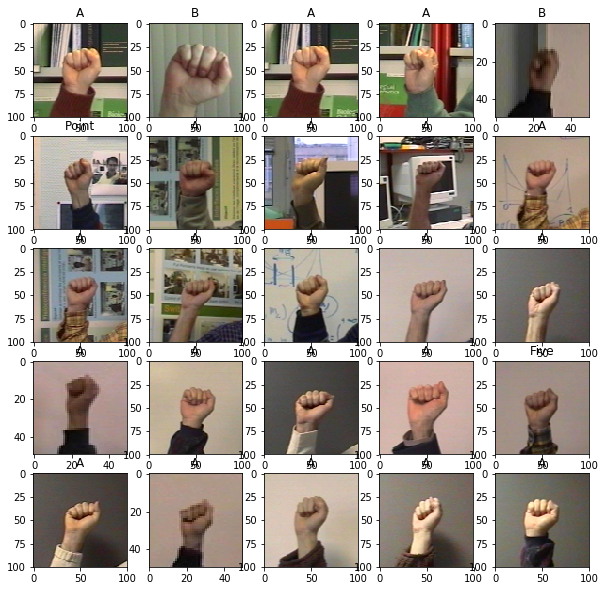

In [10]:
val_path = '/home/vivekb/python/hackathon/handgesture/test'
val_upload,x_val = predictions_df(val_path)
print(val_upload.head(10))

plt.figure(figsize=(10,10))
# sample_val = np.random.choice(full_val_path, 25, replace=False)
for i in range(1,26):
    plt.subplot(5,5,i)
    img = mpimg.imread(full_val_path[i])
#     img = mpimg.imread(sample_val[i-1])
    plt.imshow(img)
    plt.title((val_upload['Label'])[i])
plt.show()

In [23]:
val_upload.to_csv('Final_predictions_6_73.csv', columns=['FileName', 'Label'], index=False)